From https://medium.com/@oscar.sefa/twitter-sentiment-analysis-using-python-for-beginners-1ee1bc15dc86 

In [4]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from datetime import date
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
# Create a list to append tweet data
tweets_list = []
maxTweets = 1000
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('crypto since:2022-10-01 until:{today}').get_items()):
    if i>maxTweets:
        break
    tweets_list.append([tweet.content])
    
# Creating a dataframe from the tweets list above
tweets_to_df = pd.DataFrame(tweets_list, columns=['Tweets'])

In [15]:
tweets_to_df.head(10) #lists first five tweets

,Tweets
0,The prestigious 1000 Miglia is undoubtedly the...
1,@Crypto__Diva As a former crypto noob I starte...
2,… They keep talking about “波场” which I had ass...
3,Fascinating: Since Elon acquired Twitter the c...
4,@crypto_inez Never win from @crypto_inez and n...
5,@joabcg_hrba @mattomattik reject the regulatio...
6,@DidiViewing @KeithMcCullough May be too. I fi...
7,@doge_bud @elonmusk Sorry I don’t understand w...
8,I could never imagine joining Twitter. Until...
9,"From 2008 until today, crypto has managed to b..."


In [18]:
#clean the tweets with a function
def cleanTweets(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text) #removes @mentions
    text = re.sub('#','',text) #removes hastag '#' symbol
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text
tweets_to_df['cleanedTweets'] = tweets_to_df['Tweets'].apply(cleanTweets) #apply cleanTweet function to the tweet
tweets_to_df.head(10) #compares original tweets with cleaned Tweets


,Tweets,cleanedTweets
0,The prestigious 1000 Miglia is undoubtedly the...,The prestigious 1000 Miglia is undoubtedly the...
1,@Crypto__Diva As a former crypto noob I starte...,As a former crypto noob I started with USDT w...
2,… They keep talking about “波场” which I had ass...,… They keep talking about “波场” which I had ass...
3,Fascinating: Since Elon acquired Twitter the c...,Fascinating: Since Elon acquired Twitter the c...
4,@crypto_inez Never win from @crypto_inez and n...,Never win from and no win in this mont until...
5,@joabcg_hrba @mattomattik reject the regulatio...,reject the regulations and keep pushing back...
6,@DidiViewing @KeithMcCullough May be too. I fi...,May be too. I finished my pivot 24 jan with ...
7,@doge_bud @elonmusk Sorry I don’t understand w...,Sorry I don’t understand what you’re saying....
8,I could never imagine joining Twitter. Until...,I could never imagine joining Twitter. Until...
9,"From 2008 until today, crypto has managed to b...","From 2008 until today, crypto has managed to b..."


In [19]:
tweets_to_df.to_csv('tweets_crypto.csv') #write dataframe into csv file
savedTweets = pd.read_csv('tweets_crypto.csv',index_col=0) #reads csv file

In [20]:
#get subjectivity and polarity of tweets with a function
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#get polarity with a function
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
savedTweets['Subjectivity'] = savedTweets['cleanedTweets'].apply(getSubjectivity)
savedTweets['Polarity'] = savedTweets['cleanedTweets'].apply(getPolarity)
savedTweets.drop('Tweets', axis=1).head() #shows polarity and subjectivity of each tweet and drops the uncleaned tweets column

,cleanedTweets,Subjectivity,Polarity
0,The prestigious 1000 Miglia is undoubtedly the...,0.675000,0.637500
1,As a former crypto noob I started with USDT w...,0.150000,0.000000
2,… They keep talking about “波场” which I had ass...,0.000000,0.000000
3,Fascinating: Since Elon acquired Twitter the c...,0.795238,0.161905
4,Never win from and no win in this mont until...,0.400000,-0.400000


In [21]:
#create a function to check negative, neutral and positive analysis
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'
    
savedTweets['Analysis'] = savedTweets['Polarity'].apply(getAnalysis)

In [22]:
savedTweets['Analysis'].value_counts() #shows the counts of tweets' polarity

Positive    28
Neutral      9
Negative     4
Name: Analysis, dtype: int64

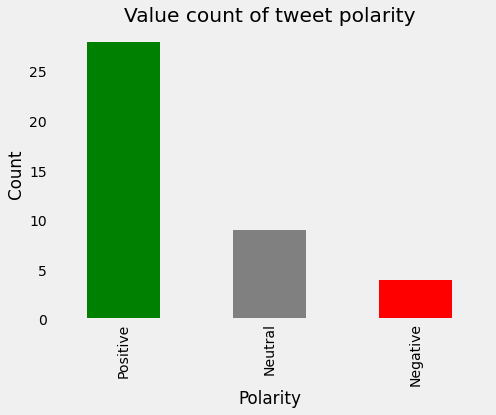

In [23]:
#plot a bar graph to show count of tweet sentiment
fig = plt.figure(figsize=(7,5))
color = ['green','grey','red']
savedTweets['Analysis'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of tweet polarity')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'Distribution of polarity')

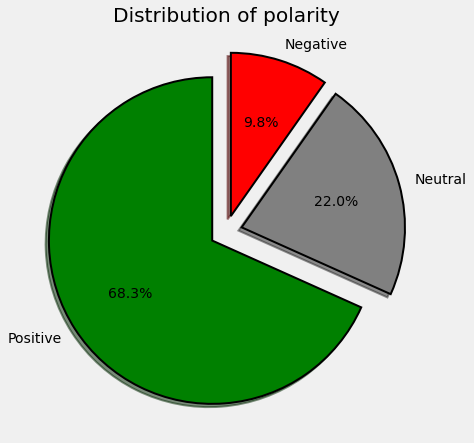

In [24]:
#pie chart to show percentage distribution of polarity
fig = plt.figure(figsize=(7,7))
colors = ('green', 'grey', 'red')
wp={'linewidth':2, 'edgecolor': 'black'}
tags=savedTweets['Analysis'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, 
         startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribution of polarity')

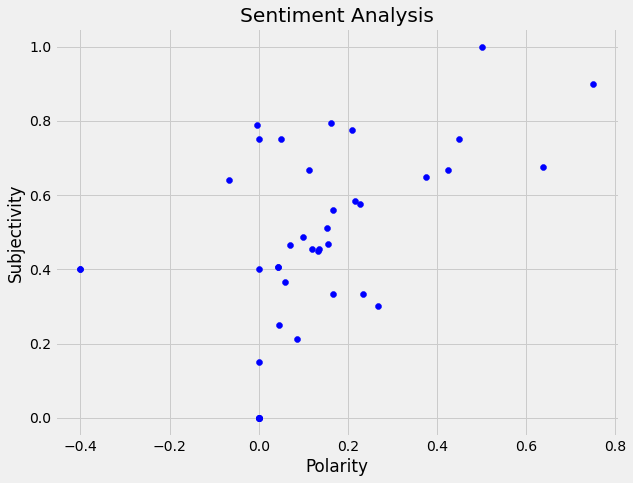

In [25]:
#plot the polarity and subjectivity on a scatter plot
plt.figure(figsize=(9,7))
for i in range(0,savedTweets.shape[0]):
    plt.scatter(savedTweets['Polarity'][i],savedTweets['Subjectivity'][i], color='blue')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

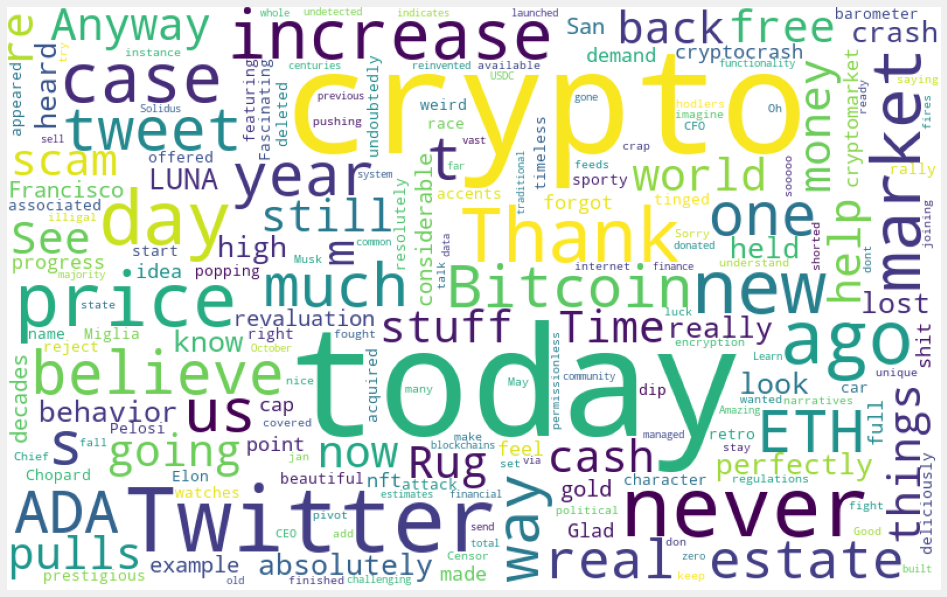

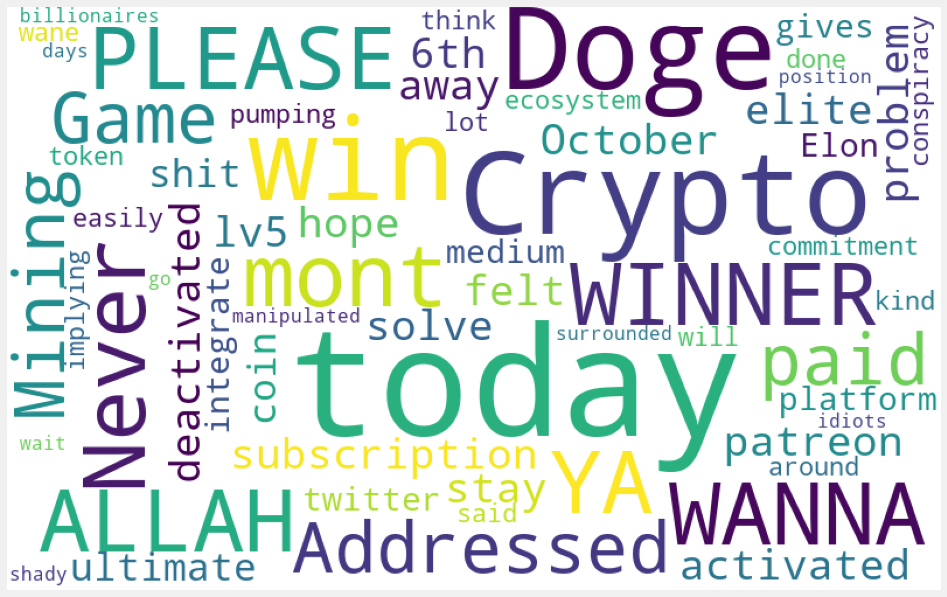

In [26]:
#create a function for wordcloud
def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()
#wordcloud for positive tweets
posTweets = savedTweets.loc[savedTweets['Analysis']=='Positive', 'cleanedTweets']
create_wordcloud(posTweets)
#wordcloud for negative tweets
negTweets = savedTweets.loc[savedTweets['Analysis']=='Negative', 'cleanedTweets']
create_wordcloud(negTweets)